
## SIMD Bitonic Sorting Network

This notebook presents the algorithm that evaluates a Bitonic Sorting Network using the _max_ function and SIMD computations. This approach allows to easily write the same algorithm using the CKKS primitives.

### Importing libraries

The *numpy* library will be useful as it will help us simulate SIMD computations. We also use *math* to compute logarithms and *matplotlib* to plot some numbers

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import statistics

Defining a class to handle Chebyshev approximations

In [2]:
class Chebyshev:
    """
    Chebyshev(a, b, n, func)
    Given a function func, lower and upper limits of the interval [a,b],
    and maximum degree n, this class computes a Chebyshev approximation
    of the function.
    Method eval(x) yields the approximated function value.
    """
    def __init__(self, a, b, n, func):
        self.a = a
        self.b = b
        self.func = func

        bma = 0.5 * (b - a)
        bpa = 0.5 * (b + a)
        f = [func(math.cos(math.pi * (k + 0.5) / n) * bma + bpa) for k in range(n)]
        fac = 2.0 / n
        self.c = [fac * sum([f[k] * math.cos(math.pi * j * (k + 0.5) / n)
                  for k in range(n)]) for j in range(n)]

    def eval(self, x):
        a,b = self.a, self.b
        #assert(a <= x <= b)
        y = (2.0 * x - a - b) * (1.0 / (b - a))
        y2 = 2.0 * y
        (d, dd) = (self.c[-1], 0)             # Special case first step for efficiency
        for cj in self.c[-2:0:-1]:            # Clenshaw's recurrence
            (d, dd) = (y2 * d - dd + cj, d)
        return y * d - dd + 0.5 * self.c[0]   # Last step is different
    
def relu(x):
    return np.maximum(0, x)

def inf_norm(real, approx):
    norm = 0
    for i in range(len(real)):
        diff = abs(real[i] - approx[i])
        if diff > norm:
            norm = diff
    return norm

## Defining primitive functions

This set of functions can be trivially written as CKKS homomorphic operations

In [3]:
def add(a, b):
    """
    Adds two arrays element-wise.

    Parameters:
    a (array-like): First input array.
    b (array-like): Second input array.

    Returns:
    numpy.ndarray: Element-wise sum of input arrays.
    """
    return np.add(a, b)

def add_many(values):
    """
    Sums up multiple arrays contained in the values list.

    Parameters:
    values (list of array-like): List containing arrays to be summed.

    Returns:
    numpy.ndarray: Sum of all arrays in the values list.
    """
    res = np.zeros(len(values[0]), dtype=int)
    for value in values:
        res = add(res, value)
    return res

def sub(a, b):
    """
    Subtracts one array from another element-wise.

    Parameters:
    a (array-like): The array to be subtracted from.
    b (array-like): The array to subtract.

    Returns:
    numpy.ndarray: Element-wise difference of the two input arrays.
    """
    return np.add(a, -b)

def mul(a, b):
    """
    Multiplies two arrays element-wise.

    Parameters:
    a (array-like): First input array.
    b (array-like): Second input array.

    Returns:
    numpy.ndarray: Element-wise product of input arrays.
    """
    return np.multiply(a, b)

def mask(a, index):
    """
    Masks elements of array a at the specified index with 1 and multiplies with the array.

    Parameters:
    a (array-like): The input array.
    index (int): Index to be masked.

    Returns:
    numpy.ndarray: Array with specified index masked with 1.
    """
    mask_vector = np.zeros(len(a), dtype=int)
    mask_vector[index] = 1
    return mul(a, mask_vector)

def rot(a, index):
    """
    Rotates the array to the left by the specified number of positions.

    Parameters:
    a (array-like): The input array.
    index (int): Number of positions to rotate the array to the left.

    Returns:
    numpy.ndarray: Array rotated to the left by the specified number of positions.
    """
    return np.roll(a, -index)

def f_min(a, b):
    """
    Computes the element-wise minimum of two arrays.

    Parameters:
    a (array-like): First input array.
    b (array-like): Second input array.

    Returns:
    numpy.ndarray: Element-wise minimum of the two input arrays.
    """
    ans = []
    for i in range(len(a)):
        ans.append(min(a[i], b[i]))
    return np.array(ans)


def f_min_cheby(a, b):
    """
    Computes the element-wise minimum of two arrays.

    Parameters:
    a (array-like): First input array.
    b (array-like): Second input array.

    Returns:
    numpy.ndarray: Element-wise minimum of the two input arrays.
    """
    return sub(a, np.vectorize(poly_relu_cheby.eval)(sub(a, b)))

Now we define the _swap_ function that will heavily be used throughout the evaluation of the Sorting Network

In [4]:
def swap_simd(a, delta, b = 0, l = 0, poly = True):    
    """
    Computes a parallel evaluation of a Sorting Network

    Parameters:
    a (array-like): Input array
    delta (int): The value of delta. In a sorting network, it specifies the "length of the arrows".
    r (int): The current round of the sorting network
    s (int): The current stage of the sorting network

    Returns:
    numpy.ndarray: Element-wise minimum of the two input arrays.
    """
    rot_positive = rot(a, delta)
    rot_negative = rot(a, -delta)
    
    # This is the evaluation of the non-linear function
    
    if poly:
        f = f_min_cheby(a, rot_positive)
    else:
        f = f_min(a, rot_positive)
            
    m1 = f
    m2 = sub(add(a, rot_negative), rot(f, -delta))
    m3 = sub(add(a, rot_positive), f)
    m4 = rot(f, -delta)
    
    masks = generate_masks(len(a), b, l)
    
    return add_many([mul(m1, masks[0]), 
                     mul(m2, masks[1]),
                     mul(m3, masks[2]),
                     mul(m4, masks[3])])

In [5]:
def generate_masks(length, b, l):
    """
    Da commentare
    """
    mask_1 = []
    mask_2 = []
    mask_3 = []
    mask_4 = []
    
    
    while len(mask_1) < length:    
        for _ in range(2 ** l):
            for _ in range(2 ** (b - l)):
                mask_1.append(1)
                mask_2.append(0)
                mask_3.append(0)
                mask_4.append(0)

            for _ in range(2 ** (b - l)):
                mask_1.append(0)
                mask_2.append(1)
                mask_3.append(0)
                mask_4.append(0)

        if len(mask_1) + (2 ** b) >= length:
            break
            
        for _ in range(2 ** l):
            for _ in range(2 ** (b - l)):
                mask_1.append(0)
                mask_2.append(0)
                mask_3.append(1)
                mask_4.append(0)
                
            for _ in range(2 ** (b - l)):
                mask_1.append(0)
                mask_2.append(0)
                mask_3.append(0)
                mask_4.append(1)

    
    return [mask_1, mask_2, mask_3, mask_4]

### Evaluating a Network

## Sorting 16 elements

In [25]:
n = 16

a = np.arange(n) / n
np.random.shuffle(a)

vec = np.copy(a)
sorted_a = np.copy(a)
sorted_a.sort()

print(vec)

[0.0625 0.1875 0.9375 0.375  0.25   0.875  0.8125 0.125  0.4375 0.5
 0.6875 0.     0.625  0.3125 0.75   0.5625]


In [26]:
vec = np.copy(a)
poly_relu_cheby = Chebyshev(-1, 1, 26, relu)

for b in range(int(math.log2(n))):
    for l in range(b + 1): 
        delta = 2 ** (b - l)
        vec = swap_simd(vec, delta, b, l, poly = True) 
        
#print("Before: {}\nAfter: {}".format(a, vec))
print("Infinity norm error: {}".format(inf_norm(sorted_a, vec)))

Infinity norm error: 0.006738609097199699


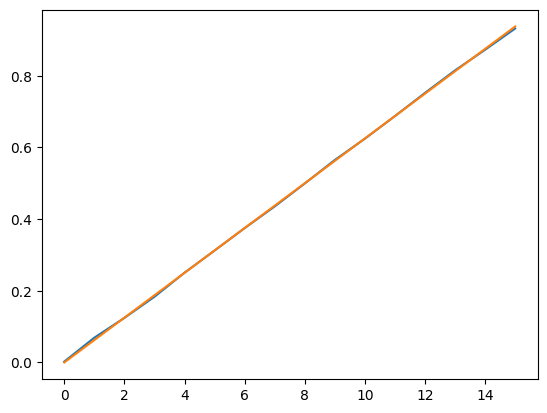

In [28]:
plt.plot(vec)
plt.plot(sorted_a)